In [1]:
import sys
import cartopy
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.patches import Polygon
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
from scipy.interpolate import griddata
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature

In [2]:
def regrid_data(lat_in, lon_in, lat_out, lon_out, input_data):
    '''
    resample spitial data
    '''
    print("regrid_data")
    if len(np.shape(lat_in)) == 1:
        lon_in_2D, lat_in_2D = np.meshgrid(lon_in,lat_in)
        lon_in_1D            = np.reshape(lon_in_2D,-1)
        lat_in_1D            = np.reshape(lat_in_2D,-1)
    elif len(np.shape(lat_in)) == 2:
        lon_in_1D            = np.reshape(lon_in,-1)
        lat_in_1D            = np.reshape(lat_in,-1)
    else:
        print("ERROR: lon_in has ", len(np.shape(lat_in)), "dimensions")

    if len(np.shape(lat_out)) == 1:
        lon_out_2D, lat_out_2D = np.meshgrid(lon_out,lat_out)
    elif len(np.shape(lat_out)) == 2:
        lon_out_2D            = lon_out
        lat_out_2D            = lat_out
    else:
        print("ERROR: lon_out has ", len(np.shape(lat_in)), "dimensions")

    # Check NaN - input array shouldn't have NaN
    value_tmp = np.reshape(input_data,-1)
    value     = value_tmp[~np.isnan(value_tmp)]
    
    # ======= CAUTION =======
    lat_in_1D = lat_in_1D[~np.isnan(value_tmp)]  # here I make nan in values as the standard
    lon_in_1D = lon_in_1D[~np.isnan(value_tmp)]
    # print("shape value = ", np.shape(value))
    # print("shape lat_in_1D = ", np.shape(lat_in_1D))
    # print("shape lon_in_1D = ", np.shape(lon_in_1D))
    # =======================
    
    Value = griddata((lon_in_1D, lat_in_1D), value, (lon_out_2D, lat_out_2D), method="linear")

    return Value

In [3]:
def read_gridinfo(file_path,gridinfo_path):
    '''
    read read_gridinfo
    '''
    print("read_gridinfo")
    gridinfo    = Dataset(gridinfo_path, mode='r')
    isoilm      = gridinfo.variables["isoil"][:,:] 
    iveg        = gridinfo.variables["iveg"][:,:] 
    GWdz        = gridinfo.variables["dtb"][:,:]
    
    lat_in      = gridinfo.variables["latitude"][:]
    lon_in      = gridinfo.variables["longitude"][:]
    
    file        = Dataset(file_path, mode='r')
    lat_out     = file.variables["lat"][:,:]
    lon_out     = file.variables["lon"][:,:]
    nlat        = len(lat_out[:,0])
    nlon        = len(lon_out[0,:])

    
    # define regrid vars
    isoilm_regrid     = regrid_data(lat_in, lon_in, lat_out, lon_out, isoilm)
    iveg_regrid       = regrid_data(lat_in, lon_in, lat_out, lon_out, iveg)
    GWdz_regrid       = regrid_data(lat_in, lon_in, lat_out, lon_out, GWdz)
    
    return (isoilm_regrid, iveg_regrid, GWdz_regrid)

In [4]:
def read_off_wb(lis_hist_path):
    
    '''
    read lis_hist restart file where the data come from offline simulations
    '''
    
    print("read_off_wb")
    # read in the last time step which is the data interpolated from offline
    offline     = Dataset(lis_hist_path, mode='r')
    wbliq_off   = offline.variables["SoilMoist_inst"][-1,:,:,:]
    GWwb_off    = offline.variables["GWwb_tavg"][-1,:,:]
    WTD_off     = offline.variables["WaterTableD_tavg"][-1,:,:]    
    nlat        = len(WTD_off[:,0])
    nlon        = len(WTD_off[0,:])
    nsoil       = 6
    wbice_off   = np.zeros((nsoil,nlat,nlon))
    
    return (wbliq_off, wbice_off, GWwb_off, WTD_off)

In [5]:
def read_lis_wb(file_path):
    
    '''
    read lis wb
    '''
    
    print("read_lis_wb")
    file        = Dataset(file_path, mode='r')
    wbliq       = file.variables["SoilMoist_inst"][:,:,:]
    GWwb        = file.variables["GWwb_tavg"][:,:]
    WTD         = file.variables["WaterTableD_tavg"][:,:]
    
    nlat        = len(WTD[:,0])
    nlon        = len(WTD[0,:])
    nsoil       = 6
    wbice       = np.zeros((nsoil,nlat,nlon))
    
    return (wbliq, wbice, GWwb, WTD)

In [6]:
def read_rst_wb(file_path, lis_rst_path):
    
    '''
    read rst wb
    '''
    
    print("read_rst_wb")
    lis_rst     = Dataset(lis_rst_path, mode='r')
    wbliq       = lis_rst.variables["WB"][:,:]
    wbice       = lis_rst.variables["WBICE"][:,:]
    GWwb        = lis_rst.variables["GWWB"][:]
    WTD         = lis_rst.variables["WTD"][:]
    lat_in      = lis_rst.variables["lat"][:]  
    lon_in      = lis_rst.variables["lon"][:]  
    
    file        = Dataset(file_path, mode='r')
    lat_out     = file.variables["lat"][:,:]
    lon_out     = file.variables["lon"][:,:]
    nlat        = len(lat_out[:,0])
    nlon        = len(lon_out[0,:])
    nsoil       = 6
    
    wbliq_regrid= np.zeros((nsoil,nlat,nlon))
    wbice_regrid= np.zeros((nsoil,nlat,nlon))
    
    for l in np.arange(6):
        wbliq_regrid[l,:,:] = griddata((lon_in, lat_in), wbliq[l,:], (lon_out, lat_out), method="linear")
        wbice_regrid[l,:,:] = griddata((lon_in, lat_in), wbice[l,:], (lon_out, lat_out), method="linear")
        
    GWwb_regrid = griddata((lon_in, lat_in), GWwb, (lon_out, lat_out), method="linear")
    WTD_regrid  = griddata((lon_in, lat_in), WTD, (lon_out, lat_out), method="linear")
        
    return (wbliq_regrid, wbice_regrid, GWwb_regrid, WTD_regrid)

In [7]:
def read_bch_sucs_ssat(file_path,gridinfo_path):
    
    '''
    read bch sucs ssat from gridinfo file
    '''
    print("read_bch_sucs_ssat")
    gridinfo    = Dataset(gridinfo_path, mode='r')
    bch_vec     = gridinfo.variables["bch_vec"][:,:,:] 
    sucs_vec    = gridinfo.variables["sucs_vec"][:,:,:]*1000. # from m to mm
    ssat_vec    = gridinfo.variables["ssat_vec"][:,:,:] 
    lat_in      = gridinfo.variables["latitude"][:]
    lon_in      = gridinfo.variables["longitude"][:]
    
    file        = Dataset(file_path, mode='r')
    lat_out     = file.variables["lat"][:,:]
    lon_out     = file.variables["lon"][:,:]
    nlat        = len(lat_out[:,0])
    nlon        = len(lon_out[0,:])
    nsoil       = 6
    
    # define regrid vars
    bch_vec_regrid    = np.zeros((nsoil,nlat,nlon))
    sucs_vec_regrid   = np.zeros((nsoil,nlat,nlon))
    ssat_vec_regrid   = np.zeros((nsoil,nlat,nlon))
    
    for l in np.arange(6):
        bch_vec_regrid[l,:,:]  = regrid_data(lat_in, lon_in, lat_out, lon_out, bch_vec[l,:,:])
        sucs_vec_regrid[l,:,:] = regrid_data(lat_in, lon_in, lat_out, lon_out, sucs_vec[l,:,:])
        ssat_vec_regrid[l,:,:] = regrid_data(lat_in, lon_in, lat_out, lon_out, ssat_vec[l,:,:])
    
    return (bch_vec_regrid, sucs_vec_regrid, ssat_vec_regrid)

In [8]:
def cal_bch_sucs_ssat(lis_input_path):
        
    '''
    calculate bch sucs ssat by using high-res sand/clay/silt fraction used in LIS-CABLE 
    '''
    
    print("cal_bch_sucs_ssat")
    
    lis_input   = Dataset(lis_input_path, mode='r')
    sand_vec    = lis_input.variables["SAND_VEC"][:,:,:] 
    clay_vec    = lis_input.variables["CLAY_VEC"][:,:,:] 
    silt_vec    = lis_input.variables["SILT_VEC"][:,:,:] 
    ocsoil_vec  = lis_input.variables["OCSOIL_VEC"][:,:,:] 

    bch_vec     = (1.0-ocsoil_vec) * ( 3.1 + 15.7*clay_vec - 0.3*sand_vec )+ ocsoil_vec*3.0
    sucs_vec    = (1.0-ocsoil_vec) * 10.0 * 10.0**( 1.54 - 0.95*sand_vec + 0.63*silt_vec ) + ocsoil_vec*10.3
    ssat_vec    = (1.0-ocsoil_vec) * ( 0.505 - 0.142*sand_vec - 0.037*clay_vec ) + ocsoil_vec*0.6
                    
    return (bch_vec, sucs_vec, ssat_vec)        

In [9]:
def spatial_map_single_plot_diff(wrf_path, wtd, WTD):

    wtd      = wtd/1000.
    WTD      = WTD/1000.
    wtd_diff = WTD-wtd
    
    # read lat and lon outs
    wrf      = Dataset(wrf_path,  mode='r')
    lons     = wrf.variables['XLONG'][0,:,:]
    lats     = wrf.variables['XLAT'][0,:,:]


    # ================== Start Plotting =================
    fig = plt.figure(figsize=(6,5))
    ax = plt.axes(projection=ccrs.PlateCarree())

    plt.rcParams['text.usetex']     = False
    plt.rcParams['font.family']     = "sans-serif"
    plt.rcParams['font.serif']      = "Helvetica"
    plt.rcParams['axes.linewidth']  = 1.5
    plt.rcParams['axes.labelsize']  = 14
    plt.rcParams['font.size']       = 14
    plt.rcParams['legend.fontsize'] = 14
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14

    almost_black                    = '#262626'
    # change the tick colors also to the almost black
    plt.rcParams['ytick.color']     = almost_black
    plt.rcParams['xtick.color']     = almost_black

    # change the text colors also to the almost black
    plt.rcParams['text.color']      = almost_black

    # Change the default axis colors from black to a slightly lighter black,
    # and a little thinner (0.5 instead of 1)
    plt.rcParams['axes.edgecolor']  = almost_black
    plt.rcParams['axes.labelcolor'] = almost_black

    # set the box type of sequence number
    props = dict(boxstyle="round", facecolor='white', alpha=0.0, ec='white')

    # =============== CHANGE HERE ===============
    clevs = [-4,-3,-2,-1.5,-1,-0.5,0.5,1,1.5,2,3,4]
    # clevs = [0,2,4,6,8,10,12,14,16,18,20]
    cmap  = plt.cm.seismic
    
    # start plotting
    ax.set_extent([135,155,-40,-25])
    ax.coastlines(resolution="50m",linewidth=1)

    # Add gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='black', linestyle='--')
    gl.xlabels_top   = False
    gl.ylabels_right = False
    gl.xlines        = True

    gl.xlocator  = mticker.FixedLocator([135,140,145,150,155])
    gl.ylocator  = mticker.FixedLocator([-40,-35,-30,-25])

    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size':10, 'color':'black'}
    gl.ylabel_style = {'size':10, 'color':'black'}

    plt.contourf(lons, lats, wtd_diff, clevs, transform=ccrs.PlateCarree(), cmap=cmap, extend='both') # 

    cb = plt.colorbar(ax=ax, orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
    cb.ax.tick_params(labelsize=10)
    plt.title("WTD_diff", size=16)

    message = "lis-calc_lis_rst_wtd"

    plt.savefig('/g/data/w97/mm3972/scripts/Drought/drght_2017-2019/plots/WTD_sudden_change/spatial_map_'+message+'.png',dpi=300)

In [10]:
def iterative_wtd(file_path, gridinfo_path, lis_input_path, lis_hist_path, lis_rst_path):

    '''
    Iteratively calcs the water table depth by equating the mass of water in the
    soil column to the mass of a hydrostatic column inegrated from the surface to the
    water table depth
    '''
    
    print("iterative_wtd")
    
    include_aquifer = True
    calc_para       = True
    offline_wb      = False
    liscable_wb     = True
    lisrst_wb       = True
    nsoil           = 6           # soil layers
    m2mm            = 1000.
    den_rat         = 0.921
    wtd_uncert      = 0.1         # uncertaintiy in wtd calcultations [mm]
    wtd_iter_max    = 20          # maximum number of iterations to find the water table depth    
    wtd_min         = 10.0        # minimum wtd [mm]
    wtd_max         = 1000000.0   # maximum wtd [mm]
    zse_vec         = [0.022, 0.058, 0.154, 0.409, 1.085, 2.872]
    
    # =================================== read data ===================================
    isoilm, iveg, GWdz = read_gridinfo(file_path,gridinfo_path)
    nlat               = len(iveg[:,0])
    nlon               = len(iveg[0,:])
    
    if calc_para:
        # read sand/silt/clay/org from lis_input.d01.nc and then calculate 
        bch_vec, sucs_vec, ssat_vec = cal_bch_sucs_ssat(lis_input_path)
        GWssat_vec                  = ssat_vec[nsoil-1,:,:]
    else: 
        # read from gridinfo
        bch_vec, sucs_vec, ssat_vec = read_bch_sucs_ssat(file_path,gridinfo_path)
        GWssat_vec                  = ssat_vec[nsoil-1,:,:]

    if liscable_wb:
        wbliq, wbice, GWwb, WTD     = read_lis_wb(file_path)
    if offline_wb:
        wbliq, wbice, GWwb, WTD_off = read_off_wb(lis_hist_path)
    if lisrst_wb:
        wbliq=None
        wbice=None
        GWwb=None
        wbliq, wbice, GWwb, WTD_rst = read_rst_wb(file_path, lis_rst_path)
        # notice, WTD in lis rst file is kept from LIS-CABLE offline simulation rather than offline sim
    
    # =================================== calc wtd ====================================
    #make code cleaner define these here
    bch_vec         = np.where(bch_vec <= 0, np.nan, bch_vec) 
    lam             = 1./bch_vec[nsoil-1,:,:]             # 1 over C&H B
    Nsucs_vec       = np.absolute(sucs_vec[nsoil-1,:,:])  # psi_saturated mm

    if include_aquifer:
        # do we include the aquifer in the calculation of wtd?
        total_depth_column = GWdz*m2mm
        tmp                = np.where(GWssat_vec-GWwb >=0, GWssat_vec-GWwb,0.)
        def_               = tmp*GWdz*m2mm
    else:
        def_               = np.zeros((nlat,nlon))
        total_depth_column = np.zeros((nlat,nlon))


    # total depth of soil column
    total_depth_column     = total_depth_column + np.sum(zse_vec)*m2mm

    # comute the total mass away from full saturation
    for l in np.arange(nsoil):
        tmp  = (ssat_vec[l,:,:]-(wbliq[l,:,:]+den_rat*wbice[l,:,:]))*zse_vec[l]*m2mm
        def_ = def_ + np.where(tmp < 0., 0., tmp)

    # find the deficit if the water table is at the bottom of the soil column
    defc = ssat_vec[nsoil-1,:,:]*(total_depth_column+Nsucs_vec/(1.-lam)*(1.-((Nsucs_vec+total_depth_column)/Nsucs_vec)**(1.-lam)))
    defc = np.where(defc < 0.1, 0.1, defc)
    # plt.contourf(defc)
    
    #initial guess at wtd
    wtd  = total_depth_column*def_/defc

    #use newtons method to solve for wtd, note this assumes homogenous column but that is ok
    for i in np.arange(nlat):
        for j in np.arange(nlon):
            if ((isoilm[i,j] != 9) and (iveg[i,j] != 16)):
                if (defc[i,j] > def_[i,j]):
                    #iterate tfor wtd
                    jlp = 0

                    while True:
                        tempa   = 1.
                        tempb   = (1.+wtd[i,j]/Nsucs_vec[i,j])**(-lam[i,j])
                        derv    = ssat_vec[nsoil-1,i,j]*(tempa-tempb) + ssat_vec[nsoil-1,i,j]

                        if (np.absolute(derv) <= 0.00000001 ):
                            derv = np.where(derv >=0, 0.00000001, -0.00000001)

                        tempa   = 1.0
                        tempb   = (1.+wtd[i,j]/Nsucs_vec[i,j])**(1.-lam[i,j])
                        deffunc = (ssat_vec[nsoil-1,i,j])*(wtd[i,j]+Nsucs_vec[i,j]/(1-lam[i,j])*(tempa-tempb)) - def_[i,j]
                        calc    = wtd[i,j] - deffunc/derv

                        if np.absolute(calc-wtd[i,j]) <= wtd_uncert:
                            wtd[i,j] = calc
                            break

                        elif (jlp >= wtd_iter_max):
                            break

                        else:
                            jlp      = jlp+1
                            wtd[i,j] = calc

                elif (defc[i,j] < def_[i,j]):

                    jlp = 0

                    while True:

                        tmpc     = Nsucs_vec[i,j] + wtd[i,j] - total_depth_column[i,j]
                        tempa    = np.absolute(tmpc/Nsucs_vec[i,j])**(-lam[i,j])
                        tempb    = (1.+wtd[i,j]/Nsucs_vec[i,j])**(-lam[i,j])
                        derv     = (ssat_vec[nsoil-1,i,j])*(tempa-tempb)

                        if (np.absolute(derv) <= 0.00000001 ):
                            derv = np.where(derv >=0, 0.00000001, -0.00000001)

                        tempa    = (np.absolute((Nsucs_vec[i,j]+wtd[i,j]-total_depth_column[i,j])/Nsucs_vec[i,j]))**(1.-lam[i,j])
                        tempb    = (1.+wtd[i,j]/Nsucs_vec[i,j])**(1.-lam[i,j])
                        deffunc  = ssat_vec[nsoil-1,i,j]*(total_depth_column[i,j] + Nsucs_vec[i,j]/(1.-lam[i,j])*(tempa-tempb))-def_[i,j]
                        calc     = wtd[i,j] - deffunc/derv

                        if np.absolute(calc-wtd[i,j]) <= wtd_uncert:
                            wtd[i,j] = calc
                            break 
                        elif (jlp == wtd_iter_max) :
                            break
                        else: 
                            jlp      = jlp + 1
                            wtd[i,j] = calc
                else:  
                    # water table depth is exactly on bottom boundary
                    wtd[i,j] = total_depth_column[i,j]

    # limit wtd to be within a psecified range
    wtd = np.where(iveg>=16, wtd_min, wtd)
    wtd = np.where(wtd>=wtd_min, wtd, wtd_min)
    wtd = np.where(wtd<=wtd_max, wtd, wtd_max)
    
    return (wtd,WTD) #WTD_rst,


iterative_wtd
read_gridinfo
regrid_data
regrid_data
regrid_data
cal_bch_sucs_ssat
read_lis_wb
read_rst_wb


/tmp/ipykernel_174602/1346631633.py:122: RuntimeWarning: invalid value encountered in double_scalars
  tempb    = (1.+wtd[i,j]/Nsucs_vec[i,j])**(-lam[i,j])
/tmp/ipykernel_174602/1346631633.py:129: RuntimeWarning: invalid value encountered in double_scalars
  tempb    = (1.+wtd[i,j]/Nsucs_vec[i,j])**(1.-lam[i,j])
/tmp/ipykernel_174602/1346631633.py:92: RuntimeWarning: invalid value encountered in double_scalars
  tempb   = (1.+wtd[i,j]/Nsucs_vec[i,j])**(-lam[i,j])
/tmp/ipykernel_174602/1346631633.py:99: RuntimeWarning: invalid value encountered in double_scalars
  tempb   = (1.+wtd[i,j]/Nsucs_vec[i,j])**(1.-lam[i,j])
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/ca

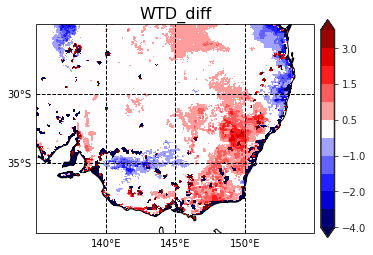

In [11]:
if __name__ == "__main__":

    file_path      = "/g/data/w97/mm3972/model/wrf/NUWRF/LISWRF_configs/drght_2017_2019_bl_pbl2_mp4_sf_sfclay2/LIS_output/LIS_HIST_201701011200_depth_varying.d01.nc"
    gridinfo_path  = "/g/data/w97/mm3972/model/cable/src/CABLE-AUX/offline/gridinfo_AWAP_OpenLandMap_ELEV_DLCM_fix_10km.nc"
    wrf_path       = "/g/data/w97/mm3972/model/wrf/NUWRF/LISWRF_configs/uniform_soil_param/drght_2017_2019/run_Jan2017/WRF_output/wrfout_d01_2017-01-01_11:00:00"
    lis_input_path = "/g/data/w97/mm3972/model/wrf/NUWRF/LISWRF_configs/drght1719_bdy_data/bdy_data/lis_input.d01.nc_vec"
    lis_hist_path  = "/g/data/w97/mm3972/model/wrf/NUWRF/LISWRF_configs/uniform_soil_param/drght_2017_2019/run_Jan2017/LIS_output/LIS.CABLE.20170101110000.d01.nc"
    # lis_rst_path   = "/g/data/w97/mm3972/model/wrf/NUWRF/LISWRF_configs/offline_rst_output/output_1719_drght/LIS_RST_CABLE_201701011100.d01.nc"
    lis_rst_path   = "/g/data/w97/mm3972/model/wrf/NUWRF/LISWRF_configs/offline_rst_output/output_1719_drght/LIS_RST_CABLE_201701011100_restart_2016.d01.nc"

    wtd,WTD        = iterative_wtd(file_path,gridinfo_path,lis_input_path,lis_hist_path,lis_rst_path)
    spatial_map_single_plot_diff(wrf_path, wtd, WTD)